# Final Project: Opioid prescription

### Shihui Wang 
#### contact: sw2804@nyu.edu

Prescription opioid overdose has become a national epidemic which impacts the health and economic well being of millions of Americans. Over-prescribing opioids certainly contributes to the misuse of the drug. This project will investigate how opioid prescriptions are related to the practioners' field, geography, local income, as well as how opioid overdose death are related to the prescription rate. 

The key dataset is a Socrata API. It contains information about prescribers name, practice address, practice type, as well as opioid prescribing rates. I combined it with census api on income per capita in 2016 by zipcode and state, as well as opioid overdose death data from opendatasoft.com by state. 

The project will answer the following questions:

- How does prescription opioid overdose death change over the years? (In the late 1990s, pharmaceutical companies begin advertising prescription painkillers as non-addicting, the subsequent widespread prescription and addiction was attributed to this period.)


- Who are prescribing opioids?


- Is prescription rate related to local per capita income? (Possible chanel: 1)Bad economy lead to depression which lead to drug abuse. 2)Poor places has less regulated healthcare industry which lead medical personale to abuse their power)


- Does more prescription lead to more overdose death?

### Packages Used

In [90]:
import pandas as pd
from sodapy import Socrata #for prescrition data
import numpy  as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from census import Census
from us import states
import requests
import json
from IPython.display import display, Image
import os
import fiona # Needed for geopandas to run
import geopandas as gpd # this is the main geopandas 
from shapely.geometry import Point, Polygon # also needed
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import statsmodels.api as sm
import statsmodels.formula.api as smf

### Prescription data

Grabbing the data

In [91]:
client = Socrata("data.cms.gov", 'jwf3Ur2ya3N6XrQBYjgV4vdXw',username="sw2804@nyu.edu",
                 password=*****)

In [92]:
results = client.get("3hwr-y534", limit=1072997)

In [93]:
results_df = pd.DataFrame.from_records(results)

In [94]:
results_df.head()

,npi,nppes_provider_first_name,nppes_provider_last_org_name,nppes_provider_state,nppes_provider_zip5,opioid_claim_count,opioid_rate,specialty_desc,total_claim_count
0,1831127620,FRED,BRESSLER,TX,77030,NaN,NaN,Otolaryngology,134
1,1588095855,REID,BREWSTER,CA,93550,NaN,NaN,Dentist,22
2,1144293044,BRUCE,BRIDEWELL,FL,34135,NaN,NaN,Family Practice,698
3,1255428645,THOMAS,BRIDGMAN,WA,98101,NaN,NaN,Dentist,40
4,1619082526,MARTIN,BRIGGS,LA,70525,NaN,NaN,Dentist,33


Cleaning the data

In [95]:
opioid = results_df.dropna()

In [96]:
opioid.rename(columns={'nppes_provider_zip5':'zipcode'}, inplace=True)
opioid

/Applications/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,npi,nppes_provider_first_name,nppes_provider_last_org_name,nppes_provider_state,zipcode,opioid_claim_count,opioid_rate,specialty_desc,total_claim_count
7,1326336751,LOUIS,BRITT,TN,38018,0,0,General Surgery,30
14,1841342003,CHARLES,BROWN,CA,92618,0,0,Dentist,16
15,1811325749,KARA,BROWN,OR,97015,0,0,Pharmacist,11
26,1194710434,JILL,BUCK,IN,46143,0,0,Optometry,81
31,1417264565,RYAN,BURKE,NM,87106,0,0,Pharmacist,11
34,1235186511,MARY,BURTON,UT,84105,0,0,Pediatric Medicine,151
54,1265506067,LARISA,CANTER,CA,92660,0,0,Ophthalmology,743
60,1164418778,BRENDA,CARRELL,MO,65804,0,0,Optometry,75
68,1649243320,RAYMOND,CAST,FL,32209,0,0,Physician Assistant,60
72,1639395957,KIMBERLY,CERTA,VA,22192,0,0,Dentist,12


### Income Data by Zipcode
Now grabbing income per capita at zipcode level in 2016 data from census

In [97]:
my_api_key = '34caee0abc641aead3785ea57203c35b70def3ee'
c = Census(my_api_key)
code = ("NAME","B19301_001E")    
#PER CAPITA INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS)
state_wealth = c.acs5.get(code, {'for': 'state:* '})
state_wealth = pd.DataFrame(state_wealth)
state_wealth.rename(columns={'NAME':'State','B19301_001E':'state_per_capita_income'}, 
                    inplace=True)
state_wealth.drop('state',axis=1,inplace=True)
state_wealth.describe()

,state_per_capita_income
count,52.000000
mean,29367.096154
std,5522.679835
min,11688.000000
25%,26092.500000
50%,28475.500000
75%,32177.750000
max,48781.000000


In [98]:
zipcode = pd.DataFrame(c.acs5.get(code, 
                                         {'for': 'zip code tabulation area: *'}))

zipcode.head()

,B19301_001E,NAME,zip code tabulation area
0,30430.0,ZCTA5 01001,01001
1,26072.0,ZCTA5 01002,01002
2,3829.0,ZCTA5 01003,01003
3,32169.0,ZCTA5 01005,01005
4,36359.0,ZCTA5 01007,01007


Making the data frame more readable by changing column names

In [99]:
zipcode.rename(columns={'zip code tabulation area':
                        'zipcode','B19301_001E':'per_capita_income'},inplace=True)

Merging these two datasets together by zipcode

In [100]:
combo = pd.merge(opioid, zipcode,
                 on='zipcode',       
                 how='left',        
                 indicator=True)

combo.rename(columns={'nppes_provider_state':'Abbreviation',
                      'nppes_provider_first_name':'first_name',
                      'nppes_provider_last_org_name':'last_name'}, inplace=True)
combo[combo["_merge"] == "left_only"]

,npi,first_name,last_name,Abbreviation,zipcode,opioid_claim_count,opioid_rate,specialty_desc,total_claim_count,per_capita_income,NAME,_merge
80,1720139348,SCOTT,ZAMVIL,CA,94143,0,0,Neurology,100,NaN,NaN,left_only
120,1306067921,ROCHELLE,AASER,TN,37933,0,0,Nurse Practitioner,137,NaN,NaN,left_only
175,1205096609,MOHAMED,ABAZEED,OH,44195,0,0,Radiation Oncology,18,NaN,NaN,left_only
182,1538509062,ELHAM,ABBAS,KS,66160,0,0,Student in an Organized Health Care Education/...,20,NaN,NaN,left_only
192,1790756179,UME,ABBAS,OH,44195,0,0,Infectious Disease,176,NaN,NaN,left_only
194,1689881781,FARHA,ABBASI,MI,48824,0,0,Psychiatry,112,NaN,NaN,left_only
258,1346276573,RICHARD,ABBOTT,CA,94143,0,0,Ophthalmology,36,NaN,NaN,left_only
306,1164693008,KHALED,ABDEL-KADER,TN,37232,0,0,Nephrology,90,NaN,NaN,left_only
308,1518181239,AHMED,ABDEL-LATIF,KY,40536,0,0,Cardiology,22,NaN,NaN,left_only
312,1982620340,MAY,ABDEL-WAHAB,OH,44195,0,0,Radiation Oncology,14,NaN,NaN,left_only


In [101]:
combo.dropna(inplace=True)
combo.drop('_merge',axis=1,inplace=True)

Adding full state name to the dataframe

In [102]:
state=pd.read_csv('https://github.com/jasonong/List-of-US-States/raw/master/states.csv')

In [103]:
combo2=pd.merge(combo,state,on='Abbreviation',how='left',indicator=True)
combo2[combo2["_merge"] == "left_only"]
combo2.dropna(inplace=True)
combo2.drop('_merge',axis=1,inplace=True)

### Opioid overdose data

In [104]:
url='https://data.opendatasoft.com/api/records/1.0/search/?dataset=prescription-opioid-overdose-deaths-and-death-rate-per-100000-population-age-adj%40public&rows=867&facet=prescription_opioid_overdose_deaths_missing_reason&facet=footnotes&facet=location&facet=year'

In [105]:
r=requests.get(url)

In [106]:
print(r.headers["content-type"])


application/json; charset=utf-8


In [107]:
data= json.loads(r.content.decode("utf-8"))

In [108]:
df=pd.DataFrame(data['records'])
dff=pd.DataFrame(df['fields'].tolist())
dff.drop('prescription_opioid_overdose_deaths_missing_reason',axis=1,inplace=True)
death=dff.set_index('year').loc['2015']
death.rename(columns={'location':'State'}, inplace=True)
death.describe()

,prescription_opioid_overdose_deaths
count,51.000000
mean,443.098039
std,417.159454
min,21.000000
25%,124.500000
50%,340.000000
75%,616.000000
max,1800.000000


### Opioid Overdose Death Trend

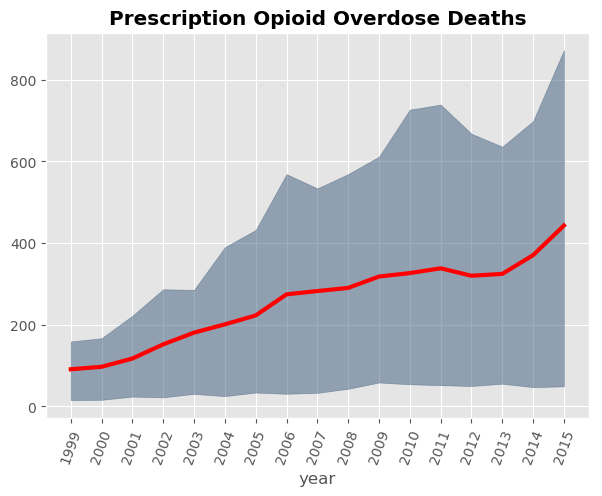

In [109]:
plt.style.use('ggplot')
fig, ax  = plt.subplots(figsize = (7,5))

dff_mean=dff.groupby('year').mean()
dff_q90=dff.groupby('year').prescription_opioid_overdose_deaths.quantile(0.90)
dff_q10=dff.groupby('year').prescription_opioid_overdose_deaths.quantile(0.10)

dff_mean.plot(ax = ax, color = "red", lw = 3, figsize = (7,5),label="Mean")

ax.fill_between(dff_mean.index, dff_q10, dff_q90, color = "#3F5D7D",alpha=0.5)

ax.set_title('Prescription Opioid Overdose Deaths',fontweight = "bold")
ax.set_xticklabels(range(1999,2016))
ax.tick_params(axis='x', rotation=70)

ax.legend().set_visible(False)

The mean prescription opioid overdoes death, represented by the red line, increased dramatically after the late 1990s. In addition, the variations in state-level opioid overdose death also increase over the years, mainly due to the increase in the upper quantile. 

### Final Data Frame

Adding state-level income data first

In [110]:
combo3=pd.merge(combo2,death,on='State',how='left',indicator=True)
combo3.drop(['NAME','_merge'],axis=1,inplace=True)

Final Data Frame

In [111]:
final_df=pd.merge(combo3,state_wealth,on='State',how='left')
final_df

,npi,first_name,last_name,Abbreviation,zipcode,opioid_claim_count,opioid_rate,specialty_desc,total_claim_count,per_capita_income,State,prescription_opioid_overdose_deaths,state_per_capita_income
0,1326336751,LOUIS,BRITT,TN,38018,0,0,General Surgery,30,32143.0,Tennessee,853.0,26019.0
1,1841342003,CHARLES,BROWN,CA,92618,0,0,Dentist,16,49991.0,California,1414.0,31458.0
2,1811325749,KARA,BROWN,OR,97015,0,0,Pharmacist,11,29906.0,Oregon,228.0,28822.0
3,1194710434,JILL,BUCK,IN,46143,0,0,Optometry,81,30999.0,Indiana,279.0,26117.0
4,1417264565,RYAN,BURKE,NM,87106,0,0,Pharmacist,11,27810.0,New Mexico,211.0,24459.0
5,1235186511,MARY,BURTON,UT,84105,0,0,Pediatric Medicine,151,39569.0,Utah,423.0,25600.0
6,1265506067,LARISA,CANTER,CA,92660,0,0,Ophthalmology,743,78374.0,California,1414.0,31458.0
7,1164418778,BRENDA,CARRELL,MO,65804,0,0,Optometry,75,31186.0,Missouri,439.0,27044.0
8,1649243320,RAYMOND,CAST,FL,32209,0,0,Physician Assistant,60,13113.0,Florida,1417.0,27598.0
9,1639395957,KIMBERLY,CERTA,VA,22192,0,0,Dentist,12,40052.0,Virginia,548.0,34967.0


In [112]:
final_df.opioid_claim_count = final_df.opioid_claim_count.astype(float)
final_df.opioid_rate = final_df.opioid_rate.astype(float)
final_df.total_claim_count = final_df.total_claim_count.astype(float)

In [113]:
final_df.dtypes

npi                                     object
first_name                              object
last_name                               object
Abbreviation                            object
zipcode                                 object
opioid_claim_count                     float64
opioid_rate                            float64
specialty_desc                          object
total_claim_count                      float64
per_capita_income                      float64
State                                   object
prescription_opioid_overdose_deaths    float64
state_per_capita_income                float64
dtype: object

### Prescription by Specialty

In [114]:
g_spec=final_df.groupby('specialty_desc')

In [115]:
m_spec=g_spec.mean()

In [116]:
m_spec.sort_values('opioid_rate',ascending=False).head(10)

,opioid_claim_count,opioid_rate,total_claim_count,per_capita_income,prescription_opioid_overdose_deaths,state_per_capita_income
specialty_desc,,,,,,
Hand Surgery,99.608365,0.601982,176.333650,-8.836863e+06,770.094106,29134.121673
Interventional Pain Management,1394.197080,0.542010,2480.824818,-4.831844e+06,827.834550,28965.026156
"Assistant, Podiatric",9.333333,0.526984,28.666667,3.104533e+04,577.000000,28075.000000
Pain Management,1174.977382,0.518620,2077.787526,-3.164060e+06,853.004798,29094.891707
Orthopedic Surgery,176.789409,0.508211,369.021772,-4.123252e+06,783.332257,29270.805000
Denturist,114.000000,0.476987,239.000000,3.150600e+04,1417.000000,27598.000000
Neurosurgery,126.880944,0.441513,288.808114,-6.174456e+06,784.570336,28866.129032
Surgical Oncology,42.040189,0.390584,157.205674,-2.202946e+07,877.111111,29303.685579
Sports Medicine,95.676471,0.382460,324.223982,3.336064e+04,790.457014,29392.092760


The specialties contained in this dataset is too detailed. Therefore, I mainly looked at 7 categories investigated in [this NIH study]('https://www.ncbi.nlm.nih.gov/pubmed/25896191'). I combined small branches of surgeries into overarching "surgery" by the following code:

In [117]:
surgery=m_spec.filter(regex='Surgery',axis='index')
surgery_s=surgery.opioid_claim_count.sum()

In [118]:
pain=m_spec.filter(regex='Pain',axis='index') # I did the same for pain management
pain_s=pain.opioid_claim_count.sum()

In [119]:
dent=m_spec.filter(regex='Dent',axis='index') # and for dentistry
dent_s=dent.opioid_claim_count.sum()

I noticed non-physician prescribers like students and assitants also appeared a lot in the dataset, therefore, I lumped them into one specialty as "non-physician".

In [120]:
assistant=m_spec.filter(regex='Assistant',axis='index')
tech=m_spec.filter(regex='Tech',axis='index')
student=m_spec.filter(regex='Student',axis='index')
non_physician=assistant.opioid_claim_count.sum()+tech.opioid_claim_count.sum()
+student.opioid_claim_count.sum()
non_physician_s=non_physician

In [121]:
specialty={'Surgery':[surgery_s],'Pain Management':[pain_s],'Dentistry':[dent_s],
          'Non_physician':[non_physician_s],
           'Physical Medicine and Rehabilitation':[463.715237],
           'Emergency Medicine':[69.022202],'Family Practice':[241.814089]}
specialty_df=pd.DataFrame(specialty)
specialty_df

,Dentistry,Emergency Medicine,Family Practice,Non_physician,Pain Management,Physical Medicine and Rehabilitation,Surgery
0,134.126081,69.022202,241.814089,156.319471,2569.174462,463.715237,904.890517


Text(127.46,0.5,'Average for all specialties\n110.0')

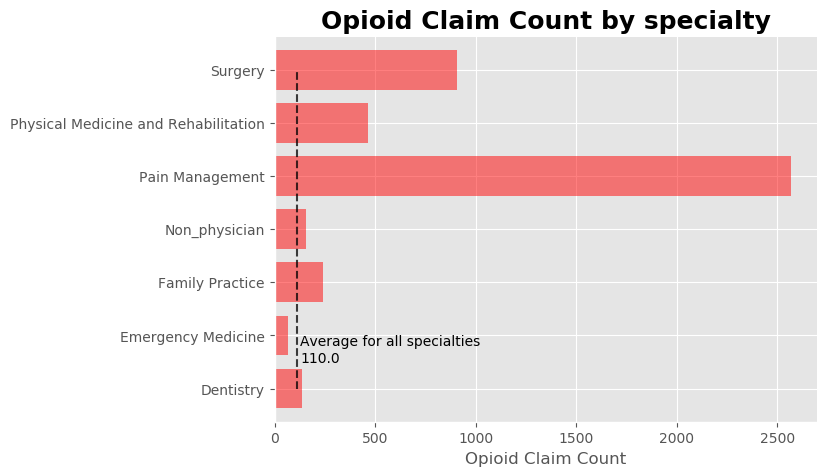

In [122]:
fig, ax = plt.subplots(figsize = (7,5))
specialty_df.T.plot(kind='barh',ax=ax,color='r',alpha=0.5, width=0.75,legend=False)
ax.set_xlabel("Opioid Claim Count")

ax.set_title("Opioid Claim Count by specialty",fontsize = 18, fontweight = "bold")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

avg=final_df.opioid_claim_count.mean()
message="Average for all specialties\n" + str(round(avg,-1))
ax.vlines(avg,0,6,linestyle="--",color="black",alpha=0.75)
ax.text(avg + 15,
        0.5,
        message,
        horizontalalignment='left')

Since prescription opioids are mainly used to relieve pain, pain management prescribes the most opioid, followed by surgery. However, Family practice and Non-physician also make above average amount of opioid prescription, which are surprising, since they are less transparent and in some case less experienced. They should be expected to handle less sensitive drugs.

### State-level Income and Overdose Death Map

I want to visualize the distribution of state-level income and overdose death, and compare them side by side to see if there are any patterns.

In [123]:
cwd = os.getcwd()

regions_shape = cwd + "/shape_files/cb_2017_us_state_500k"

In [124]:
us_map = gpd.read_file(regions_shape)

In [125]:
death_map=death.set_index('State')

In [126]:
us_map.rename(columns={'NAME':'State'},inplace=True)
us_map=us_map.merge(state_wealth,on='State',how='inner')
us_map=us_map.join(death_map,on='State',how='inner')

In [127]:
us_map.dtypes

STATEFP                                 object
STATENS                                 object
AFFGEOID                                object
GEOID                                   object
STUSPS                                  object
State                                   object
LSAD                                    object
ALAND                                    int64
AWATER                                   int64
geometry                                object
state_per_capita_income                float64
prescription_opioid_overdose_deaths    float64
dtype: object

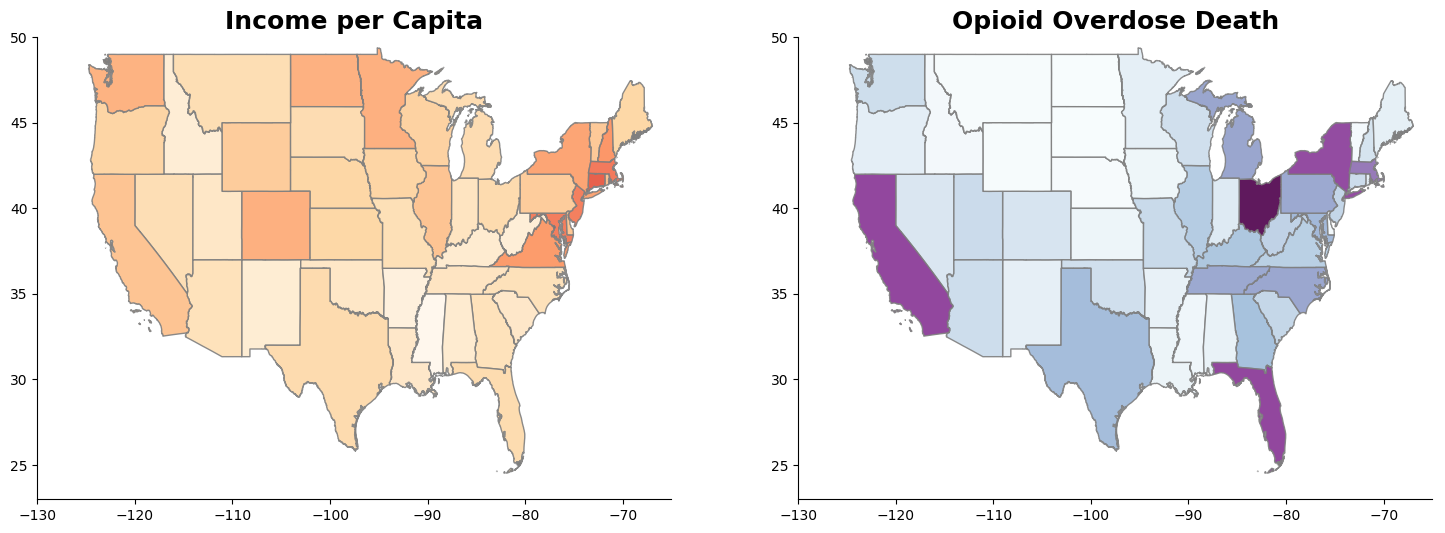

In [128]:
plt.style.use('default')
fig, ax = plt.subplots(1,2,sharex=True, figsize = (18,6))

us_map.plot(ax = ax[0],
             edgecolor='tab:grey', # Tell it the edge color
             column='state_per_capita_income', #it says color it based on this column
             cmap='OrRd',
             alpha = 0.9) # Transparent

us_map.plot(ax = ax[1],
             edgecolor='tab:grey',
             column='prescription_opioid_overdose_deaths',
             cmap='BuPu', 
             alpha = 0.9)

ax_length = range(0,2)

for var in ax_length:
    ax[var].spines["right"].set_visible(False)
    ax[var].spines["top"].set_visible(False)
    
ax[var].set_ylim(23,50)
ax[var].set_xlim(-130,-65)
ax[0].set_ylim(23,50)

ax[0].set_title('Income per Capita',fontsize = 18, fontweight = "bold")
ax[1].set_title('Opioid Overdose Death',fontsize = 18, fontweight = "bold")

plt.show()

Northeast region is the richest. Ohio, New York, California and Florida seem to have the most opioid overdose death. There is no apparent correlation. But state averages may have masked a lot of vriations, therefore I want to look at data by zipcode.

### Regression of opioid prescription on income by zipcode

In [129]:
g_zip=final_df.groupby('zipcode')

In [130]:
m_zip=g_zip.mean()
m_zip.per_capita_income=m_zip.per_capita_income*0.000001
m_zip_clean=m_zip[m_zip['per_capita_income'] > 0]

In [131]:
results = smf.ols('opioid_rate ~ per_capita_income',
                  data=m_zip_clean).fit() 
type(results) 

print(results.summary())   

                            OLS Regression Results                            
Dep. Variable:            opioid_rate   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     15.54
Date:                Sat, 12 May 2018   Prob (F-statistic):           8.13e-05
Time:                        22:23:06   Log-Likelihood:                 19101.
No. Observations:               16217   AIC:                        -3.820e+04
Df Residuals:                   16215   BIC:                        -3.818e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1025      0.00

The coefficient is negative and significant, confirming our hypothesis that poorer places have more opioid prescriptions. However, R square is small, indicating linear model may not be the best fit.

Text(0.16,0.15,'y= -0.1770x + 0.1025')

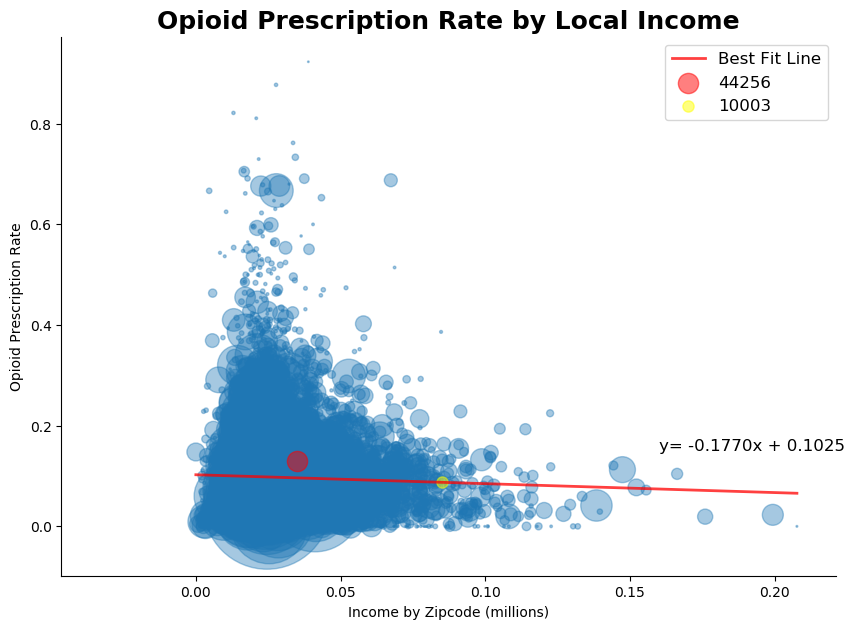

In [132]:
plt.style.use('default')
###Ploting the scatter plot:
pred = results.predict(exog = m_zip_clean["per_capita_income"].sort_values())

fig, ax = plt.subplots(figsize = (10,7))
m_zip_clean.plot('per_capita_income','opioid_rate',kind='scatter',
                 s=m_zip_clean['total_claim_count']*0.1,
                 ax=ax,alpha=0.4)

###Plotting the best fit line
ax.plot(m_zip_clean["per_capita_income"].sort_values(), pred , color = 'r', 
        linewidth = 2.0,alpha=0.75,
        label = "Best Fit Line")


###Indicating two places of interest:
ax.scatter(m_zip_clean.loc['44256']["per_capita_income"], #Ohio
           m_zip_clean.loc['44256']["opioid_rate"], 
            s=m_zip_clean.loc['44256']['total_claim_count']*0.1, 
            alpha= 0.50,color='red',label='44256')

ax.scatter(m_zip_clean.loc['10003']["per_capita_income"], #New York
           m_zip_clean.loc['10003']["opioid_rate"], 
            s=m_zip_clean.loc['10003']['total_claim_count']*0.1, 
            alpha= 0.50,color='yellow',label='10003')

###Polishing the graph:
ax.set_title("Opioid Prescription Rate by Local Income",fontsize = 18, fontweight = "bold")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_xlabel("Income by Zipcode (millions)")
ax.set_ylabel("Opioid Prescription Rate")

ax.legend(fontsize=12)
equation="y= -0.1770x + 0.1025"
ax.text(0.16,0.15,equation,fontsize=12,
        horizontalalignment='left')

The scatterplot definitly show an negtive relationship between opioid prescription rate and local income. However the shape shows that the relationship is likely non-linear. 

### Regression of Opioid Overdose death on opioid prescription rate

In [133]:
g_state=final_df.groupby('State').mean()

results2 = smf.ols('prescription_opioid_overdose_deaths ~ opioid_rate', 
                  data=g_state).fit()  
                                      
type(results2) 

print(results2.summary()) 

                                     OLS Regression Results                                    
Dep. Variable:     prescription_opioid_overdose_deaths   R-squared:                       0.004
Model:                                             OLS   Adj. R-squared:                 -0.018
Method:                                  Least Squares   F-statistic:                    0.2009
Date:                                 Sat, 12 May 2018   Prob (F-statistic):              0.656
Time:                                         22:23:09   Log-Likelihood:                -351.00
No. Observations:                                   47   AIC:                             706.0
Df Residuals:                                       45   BIC:                             709.7
Df Model:                                            1                                         
Covariance Type:                             nonrobust                                         
                  coef    std err       

The correlation is surprisingly not significant. However, it maybe because overdose death data is state-level. The average masked a lot of variation.

Text(0,0.5,'Prescription Opioid Overdose Death')

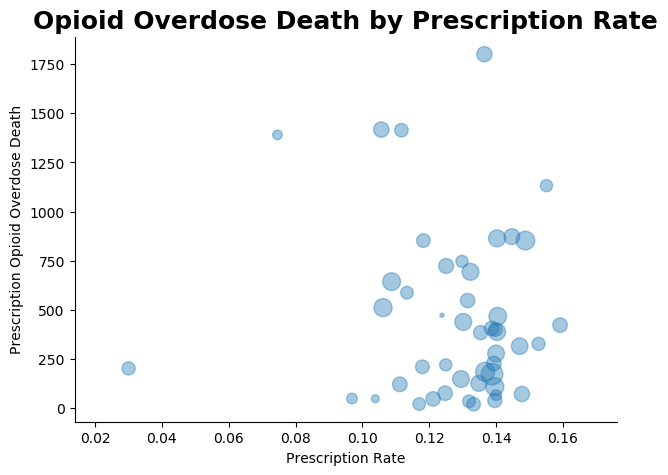

In [134]:
plt.style.use('default')
fig, ax = plt.subplots(figsize = (7,5))

g_state.plot('opioid_rate','prescription_opioid_overdose_deaths',kind='scatter',
             s=g_state['opioid_claim_count'],
                 ax=ax,alpha=0.4)

ax.set_title("Opioid Overdose Death by Prescription Rate",fontsize = 18, fontweight = "bold")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_xlabel("Prescription Rate")
ax.set_ylabel("Prescription Opioid Overdose Death")


Consitent with the regression, the scatterplot looked fairly random. 

## Conclusion

 In this project, we have visualized opioid overdose death increase in both numbers and variations since the late 1990s. Looking at specialties, an outstanding number of prescription from pain management, and above avaerage counts for non-physicians and family practices were found. More investigation should be done on whether these specialties are prescribing opioid reasonably. we have also visualized state-level income per capita and opioid overdose death on a map. Importantly, a significant correlation between local (by zipcode)income and opioid prescription rate was found. Indicating poor places have either higher demand for opioids or inadequate prescription regulation. However, the correlation between opioid prescription rate and overdose death is not significant. Data for zipcode-level overdose death may give better result. Policy maker should focus on poor neighborhoods to solve the opioid crisis. 


## Reference

[Opioid Overdose Crisis]('https://www.drugabuse.gov/drugs-abuse/opioids/opioid-overdose-crisis')